In [18]:
import pickle
import numpy as np
from PIL import Image
import csv
import os

In [2]:
with open('datasets/colorferet_sketch_to_img_map.pickle', 'rb') as f:
    colorferet_map = pickle.load(f)

In [3]:
i = 0
for k, v in colorferet_map.items():
    print(k, v)
    i += 1
    if i > 5:
        break

00001fb010_930831.jpg ['./colorferet/dvd2/gray_feret_cd1/data/images/00001fb010_930831.tif.bz2', './colorferet/dvd1/data/images/00001/00001_930831_fb_a.ppm.bz2']
00002fa010_930831.jpg ['./colorferet/dvd2/gray_feret_cd1/data/images/00002fa010_930831.tif.bz2', './colorferet/dvd1/data/images/00002/00002_930831_fa.ppm.bz2']
00003fa010_930831.jpg ['./colorferet/dvd2/gray_feret_cd1/data/images/00003fa010_930831.tif.bz2', './colorferet/dvd1/data/images/00003/00003_930831_fa_a.ppm.bz2']
00004fb010_930831.jpg ['./colorferet/dvd2/gray_feret_cd1/data/images/00004fb010_930831.tif.bz2', './colorferet/dvd1/data/images/00004/00004_930831_fb.ppm.bz2']
00005fa010_930831.jpg ['./colorferet/dvd2/gray_feret_cd1/data/images/00005fa010_930831.tif.bz2', './colorferet/dvd1/data/images/00005/00005_930831_fa.ppm.bz2']
00006fb010_930831.jpg ['./colorferet/dvd2/gray_feret_cd1/data/images/00006fb010_930831.tif.bz2', './colorferet/dvd1/data/images/00006/00006_930831_fb_a.ppm.bz2']


In [4]:
# Testing that you can transform one triangle into another
fiducial = np.array([[312, 450, 387], 
                     [348, 352, 497]])
fiducial_3d = np.array([[312, 450, 387], 
                        [348, 352, 497], 
                        [1, 1, 1]])
goal = np.array([[300, 420, 360], 
                 [350, 250, 500], 
                 [0, 0, 0]])
w = goal @ np.linalg.inv(fiducial_3d)
mat = w[:2, :2]
translation = w[:2, 2:3]
mat @ fiducial + translation

array([[300., 420., 360.],
       [350., 250., 500.]])

In [73]:
# Expects fiducial_points is 3 x 2 numpy array
def align_face(img, fiducial_points, out_width, out_height, point_targets=None):
    orig_width, orig_height = img.size
    if point_targets is None:
        point_targets = np.array([[0.375, 0.625, 0.5], [0.5, 0.5, 0.72]]) * np.array([[out_width], [out_height]])
    # Pupil 1: (0.4, 0.5), Pupil 2: (0.6, 0.5), Mouth: (0.5, 0.7)
    
    fiducial_3d = np.vstack((fiducial_points.T, np.ones((1, 3))))
    transform = np.vstack((point_targets @ np.linalg.inv(fiducial_3d), np.array([0, 0, 1])))
    transform_inv = np.linalg.inv(transform)

    data = transform_inv.flatten()[:6]
    return img.transform((out_width, out_height), Image.AFFINE, data)

In [59]:
img1 = Image.open('datasets/colorferet/original_sketch/00001.jpg')
fiducial_points = np.zeros((3, 2))
with open('datasets/colorferet/sketch_points/00001.3pts', 'r') as f:
    reader = csv.reader(f, delimiter= ' ')
    for i, row in enumerate(reader):
        fiducial_points[i] = row

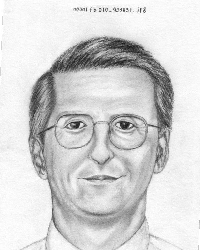

In [74]:
aligned1 = align_face(img1, fiducial_points, out_width=200, out_height=250)
aligned1.save('datasets/colorferet/aligned_sketches/00001.jpg', 'JPEG')
aligned1

In [77]:
def align_all_in_folder(src_dir, points_dir, dest_dir, out_width, out_height, src_name_to_pts_name, preprocess_fiducials=None):
    for root, _, fnames in sorted(os.walk(src_dir)):
        for fname in fnames:
            path = os.path.join(root, fname)
            try:
                img = Image.open(path)
            except Exception as err:
                print(fname, err)
                continue
            fiducial_points = np.zeros((3, 2))
            points_fname = src_name_to_pts_name(fname)
            points_path = os.path.join(points_dir, points_fname)
            try:
                with open(points_path, 'r') as f:
                    reader = csv.reader(f, delimiter= ' ')
                    for i, row in enumerate(reader):
                        fiducial_points[i] = row
            except OSError as err:
                print(fname, err)
                continue
            if preprocess_fiducials is not None:
                fiducial_points = preprocess_fiducials(fiducial_points)
            aligned = align_face(img, fiducial_points, out_width=out_width, out_height=out_height)
            out_fname_jpg = fname[:-3] + 'jpg'
            out_path = os.path.join(dest_dir, out_fname_jpg)
            aligned.save(out_path, 'JPEG')

In [75]:
align_all_in_folder('datasets/colorferet/original_sketch', 
                    'datasets/colorferet/sketch_points',
                    'datasets/colorferet/aligned_sketches',
                    200,
                    250,
                    lambda name: name[:-4] + '.3pts')

.DS_Store cannot identify image file 'datasets/colorferet/original_sketch/.DS_Store'


In [79]:
align_all_in_folder('datasets/colorferet/color', 
                    'datasets/colorferet/photo_points',
                    'datasets/colorferet/aligned_color',
                    200,
                    250,
                    lambda src: src[:5] + src[13:15] + '010_' + src[6:12] + '.3pts',
                    lambda fiducials: fiducials + np.array([[-100, 0], [-100, 0], [-100, 0]]))

00615_941031_fa.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00615fa010_941031.3pts'
00185_940422_fb.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00185fb010_940422.3pts'
00429_940422_fa.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00429fa010_940422.3pts'
00086_940422_fa.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00086fa010_940422.3pts'
00621_941121_fb.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00621fb010_941121.3pts'
00210_940422_fb.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00210fb010_940422.3pts'
00450_940422_fa.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00450fa010_940422.3pts'
00256_940128_fa.ppm [Errno 2] No such file or directory: 'datasets/colorferet/photo_points/00256fa010_940128.3pts'
00498_960627_fa.ppm [Errno 2] No such file or directory: 'datasets/colorferet/ph